# Generalization for Surface Codes with Arbitrary Distance

It begins with a generalization for a surface code. This can be observed for short-distance codes such as \$d=3\$ or \$d=5\$, where visualization is straightforward. We start by defining that for any surface code of distance \$d\$, there will be \$d^2\$ data qubits and \$d^2 - 1\$ ancillary qubits. With this, a classical distribution is presented for \$d=5\$, along with a similar geometric proposal that allows mapping the qubits arbitrarily for any \$d\$.

<div style="display: flex; justify-content: center; gap: 20px;">
  <div style="text-align: center;">
    <img src="Distance5Code.jpeg" width="400"/>
    <p style="font-size: 14px;">Figure 1: Classical Representation</p>
  </div>
  <div style="text-align: center;">
    <img src="DistribuciónD5Kayro.jpeg" width="400"/>
    <p style="font-size: 14px;">Figure 2: Proposed Representation</p>
  </div>
</div>
<p>
The previous image provides a classical representation where each qubit can be mapped to a coordinate; however, this can unnecessarily increase the grid size, especially at the edges. For this reason, a similar geometry is proposed in which all the qubits are contained within a grid of size $2d^2 - 1$. It is also worth noting that the data qubits are represented as red points, while the ancillary qubits are represented as turquoise points. The $X$ measurements are represented with blue lines, and the $Z$ measurements with pink lines.
</p>

With this new proposed geometry, an arbitrary mapping can be developed for any code of length \$d\$, as presented below:

In [38]:
#This tell us the python version that the Jupyter have
import sys
print(sys.version)

3.7.0 (default, Jun  4 2019, 10:47:24) 
[GCC Intel(R) C++ gcc 8.3 mode]


In [39]:
#!module avail python

In [40]:
#!python3 -m pip install pymatching --user

In [41]:
#Importing all the libraries usefull for this simulation
import stim
#import pymatching as pm
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
#import seaborn as sns

In [42]:
# Define the code distance
d = 5

# Define how many data qubits there will be
data_qubits = d*d
# Number of ancillary qubits
ancilla_qubits = (d*d) - 1

total_qubits = data_qubits + ancilla_qubits

In [43]:
def Qubits_coordinates(total_qubits):
    # For this section, a distribution as seen in Figure 2 is proposed
    # Two lists are initialized to store the locations on a grid like in the figure
    data_coords = []
    ancilla_coords = []
    # A loop is made to go through the entire grid containing coordinates and define each point as data or ancilla
    for i in range(total_qubits):
        for j in range(total_qubits):
            # An index can be defined to traverse the matrix continuously
            # First, the positions of the data qubits are determined
            if i%2 == 0 and j%2 == 0:
                data_coords.append((i,j))
            # The positions of the ancilla qubits are determined without considering the edges
            if i%2 != 0 and j%2 != 0:
                ancilla_coords.append((i,j))
            # Ancilla qubits on the edges are defined according to the proposed geometry in Figure 2
            # Horizontal edges
            if i == 0 and 4*j + 3 < total_qubits:
                ancilla_coords.append((i, 4*j + 3)) # This equation 4j+3 separates the odd 1,5,9... from the others 3,7,11...
            if i == total_qubits - 1 and 4*j + 1 < total_qubits:
                ancilla_coords.append((i, 4*j + 1))
            # Vertical edges
            if j == 0 and 4*i + 1 < total_qubits:
                ancilla_coords.append((4*i + 1, j))
            if j == total_qubits - 1 and 4*i + 3 < total_qubits:
                ancilla_coords.append((4*i + 3, j))

    return data_coords, ancilla_coords

# When calling this function, each qubit according to the distribution in Figure 2 is associated with an ordered pair
# This aims to obtain a bijection that relates the natural numbers with each ordered pair, following the classical numbering of the code
# Data qubits are numbered from 1 to d^2 and ancillary qubits from d^2 to total_qubits

In [44]:
# A function is proposed to create a dictionary that generates a bijection ordered pair <-> qubit number
def Qubits_pair_num(data_coords # List of ordered pairs corresponding to the data qubits,
                    ,ancilla_coords # List of ordered pairs corresponding to the ancilla qubits,
                    ,d # Code distance
):
    # Dictionary that stores ordered pair: number
    qubits_coords_num = {}
    # An ordering is proposed for the data qubits as is usual in a surface code
    data_order = sorted(data_coords, key=lambda coord: (coord[0], coord[1]))
    # Assign numbers to the ordered data qubits as desired
    for idx, coord in enumerate(data_order, start=1):
        qubits_coords_num[coord] = idx

    # Sort the ancilla qubits by ordered pairs
    ancilla_order = sorted(ancilla_coords, key=lambda coord: (coord[0], coord[1]))
    # Define the starting number for the ancilla qubits
    start_ancilla = d*d+1
    # Assign numbers to the ancilla qubits
    for idx, coord in enumerate(ancilla_order, start=start_ancilla):
        qubits_coords_num[coord] = idx

    # Invert the dictionary to obtain a function that relates qubit numbers to their coordinates and, subsequently,
    # relate the qubit numbers with their adjacent qubits
    qubits_num_coords = {num: coord for coord, num in qubits_coords_num.items()}
    
    return qubits_num_coords

In [45]:
# Define a function that will classify the ancilla qubits according to the geometry in Figure 2, determining whether an ancilla is X or Z
def Class_ancilla(qubits_num_coords # Dictionary relating qubit number to its ordered pair
                        , d # Code distance
                       ):
    # Define the starting and ending number of the ancilla qubits
    start = d*d + 1
    end = 2*d*d - 1
    total_qubits = 2*d - 1

    # Define an empty dictionary that will relate the qubit number to whether it is an X or Z stabilizer
    tipos_num = {}

    # Define an auxiliary function that will classify each qubit individually by its position
    def Stabil_coords(i, j):
        # Analyze the points inside the edges of the code
        if i % 2 == 1 and j % 2 == 1:
            if i % 4 == 1:
                return 'X' if (j % 4 == 1) else 'Z'
            else:
                return 'X' if (j % 4 == 3) else 'Z'
        # Analyze the points on the edges of the grid
        if i == 0:
            return 'X' if (j % 4 == 3) else 'Z'
        if i == total_qubits - 1:
            return 'X' if (j % 4 == 1) else 'Z'
        if j == 0:
            return 'X' if (i % 4 == 1) else 'Z'
        if j == total_qubits - 1:
            return 'X' if (i % 4 == 3) else 'Z'
        return 'Z'

    # Extract and classify each ancilla
    for num, (i, j) in qubits_num_coords.items():
        if start <= num <= end:
            tipos_num[num] = Stabil_coords(i, j)

    return tipos_num

In [46]:
# Define a distance function
def Dist(data_q, ancilla_q):
    return math.hypot(data_q[0] - ancilla_q[0], data_q[1] - ancilla_q[1])

In [47]:
def Ancil_per_data(qubits_num_coords # Dictionary that associates qubit number with ordered pair
                   , d):
    # Start by defining the radius within which ancilla qubits can exist for each data qubit
    radio = 2**(0.5)

    # Define the data qubits and where the numbering of ancilla qubits starts and ends
    data_qubits = d*d
    start  = data_qubits + 1
    end = 2*data_qubits - 1

    # Define a dictionary that will relate each data qubit number to a list representing the ancillas corresponding to that data qubit
    ancilla_per_data = {}
    
    # For each data qubit
    for data_q in range(1, data_qubits + 1):
        data_posit = qubits_num_coords[data_q]
        vecinos = []

        # Iterate over the ancilla qubits
        for ancilla_q in range(start, end + 1):
            ancilla_posit = qubits_num_coords[ancilla_q]
            if Dist(data_posit, ancilla_posit) <= radio:
                vecinos.append(ancilla_q)

        ancilla_per_data[data_q] = vecinos

    # With the dictionary defined from data to ancilla, it is more convenient to have something relating ancilla to data
    data_per_ancilla = {ancilla_q: [] for ancilla_q in range(start, end + 1)}
    for data_q, ancillas in ancilla_per_data.items():
        for ancilla_q in ancillas:
            data_per_ancilla[ancilla_q].append(data_q)
    
    return data_per_ancilla

With the previous code, a generalization is achieved for any code of distance \$d\$; once the grid is constructed as in Figure 2 and the ancillas related to each data qubit are known, the necessary gates are proposed to connect each qubit. It is important to note that after applying all the previous functions, we have three dictionaries:

* qubits\_num\_coords: Relates a qubit number to an ordered pair, containing all data and ancilla qubits.
* tipos\_num: Relates the number of each ancilla qubit to its corresponding X or Z stabilizer.
* data\_per\_ancilla: Relates each ancilla qubit to a list of data qubits that it would measure.

With this, a function is proposed to create the quantum circuit, where all qubits are first reset, and then the ancilla-data relationships are applied.

In [48]:
def Quantum_circuit(tipos_num # Dictionary relating ancilla number to X or Z
                   , data_per_ancilla # Dictionary relating each ancilla qubit number to a list of data qubits
                    , d # Code distance
                    , shots # Number of repetitions of the full code, used for statistics
                   , rounds # Complete cycle of stabilizer measurements. Each round generates different syndromes
                   ):
    # Define the number of data and ancilla qubits
    data_qubits = d*d
    ancilla_qubits = (d*d) - 1
    total_qubits = data_qubits + ancilla_qubits
    
    # Start by creating an empty circuit
    circuit = stim.Circuit()

    """
    # Propose a massive reset for all qubits
    circuit.append("R", range(1, total_qubits + 1))
    """    
    # Arrange the ancillas once more
    ancillas = sorted(tipos_num.keys())
    # Start defining each circuit and begin a loop over the rounds
    for rounds_i in range(rounds):
        # Propose a massive reset for all qubits
        circuit.append("R", range(1, total_qubits + 1))
        for i in tipos_num.keys():
            # First handle the X operators
            if tipos_num[i] == "X":
                # Get the list of associated data qubits
                data_asoc = data_per_ancilla.get(i)
                circuit.append("H", [i])
                # Apply the relation to each qubit
                for k in data_asoc:
                    circuit.append("CNOT", [i,k])
                circuit.append("H", [i])
            # Handle the Z operators
            if tipos_num[i] == "Z":
                # Get the list of associated data qubits
                data_asoc = data_per_ancilla.get(i)
                # Apply the relation to each qubit
                for k in data_asoc:
                    circuit.append("CNOT", [k,i])

            # Measure the stabilizers at this point for each element, 
            # because separating the cycles as in the Stim version allows optimization,
            # which could introduce more entanglement errors
            circuit.append("M", [i])
            circuit.append("DETECTOR", [stim.target_rec(-1)], tag=f"R{rounds_i}_A{i}")

        # Add an if-statement to reset the ancillas if it's not the last round
        if rounds_i < rounds - 1:
            circuit.append("R", list(tipos_num.keys())) 

    # Two lines suggested by DS for specialized error detection
    sampler = circuit.compile_detector_sampler()
    syndroms = sampler.sample(shots=shots)

    return circuit, syndroms

In [49]:
def Sindrome_visual(syndroms # List resulting from the circuit
                    , d
                    , measurements):
    # Start by obtaining a list of lists of booleans and split it into multiple lists representing errors per measurement
    detectors = np.array_split(circuito[1].flatten(), measurements)

    # Define the ranges of the ancilla qubits and their numbers as previously done
    data_qubits = d*d
    ancilla_qubits = (d*d) - 1
    total_qubits = data_qubits + ancilla_qubits
    
    # Define the code length and similar values to create a dictionary relating ancilla to their failure counts
    ancilla_fails = {}
    for i in range(data_qubits + 1, total_qubits + 1):
        ancilla_fails[i] = 0

    # Loop over each ancilla and each measurement list
    for measurement in range(len(detectors)):
        for j in range(ancilla_qubits):
            if detectors[measurement][j] == True:
                ancilla_fails[data_qubits + j + 1] += 1

    # At this point, there is a dictionary relating each ancilla qubit number to the number of errors it experienced per measurement
    # Propose a bar chart
    plt.figure(figsize=(20, 10))  # Size of the chart
    plt.bar(ancilla_fails.keys(), ancilla_fails.values(), color='teal', edgecolor='black')
    plt.grid(axis='y', linestyle='--', alpha=0.9)
    plt.title("Detection of change in the ancilla qubits", fontsize=20)
    plt.xlabel("Number of qubit", fontsize=20)
    plt.ylabel("Times that Detector Activate", fontsize=20)
    plt.tight_layout()
    plt.savefig("Detection of change in the ancilla qubits.png", dpi=300, bbox_inches='tight')
    plt.show()

In [54]:
# Test measurement of the system
measurements = 10000
data_ancilla_qubits = Qubits_coordinates(total_qubits)
qubits_pair_num = Qubits_pair_num(data_ancilla_qubits[0], data_ancilla_qubits[1], d)
clasificacion_ancilla = Class_ancilla(qubits_pair_num, d)
ancil_per_data = Ancil_per_data(qubits_pair_num, d)
circuito = Quantum_circuit(clasificacion_ancilla, ancil_per_data, d, 1, measurements)

# print(circuito)

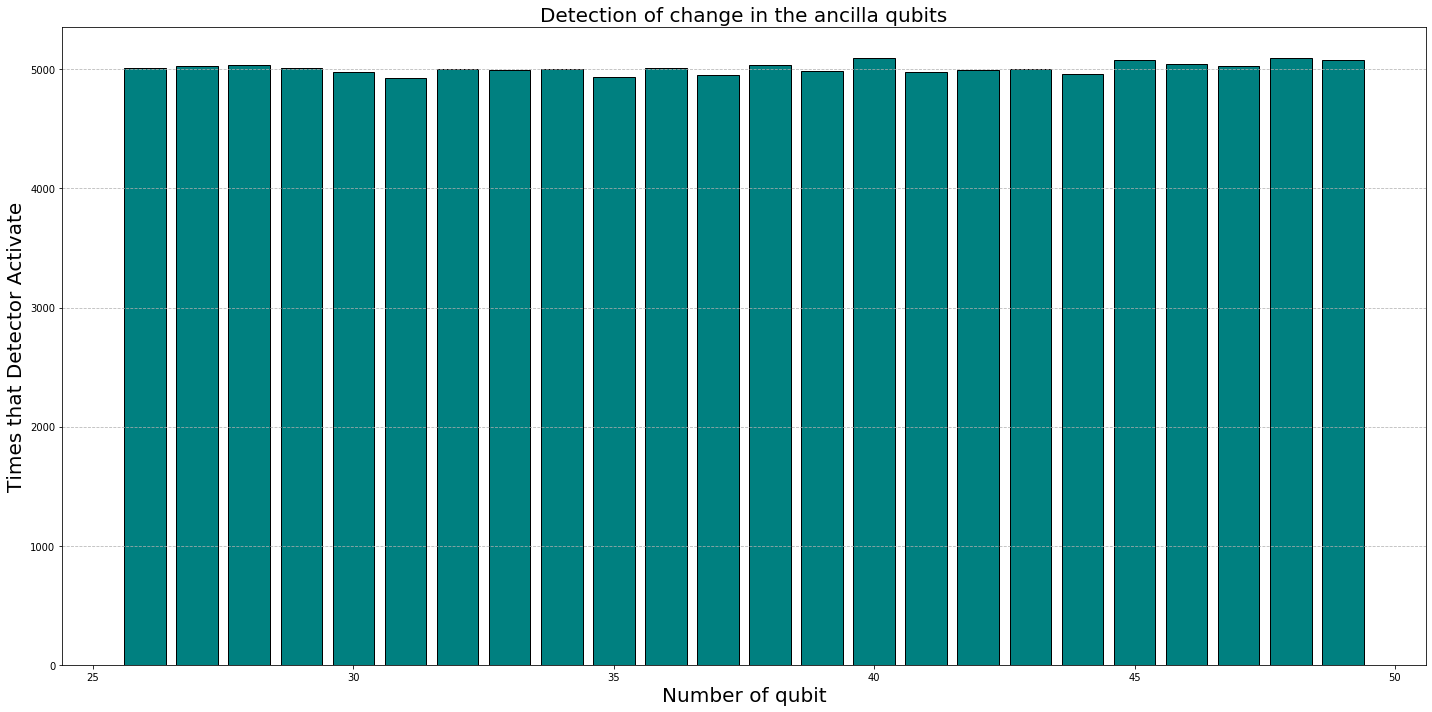

In [55]:
# Test the visualization function
# print(circuito[1])
Sindrome_visual(circuito[1], d, measurements)